#### Entrenamiento y Validación Secuencial de Red Neuronal (Local)
- **Carga y preprocesamiento de datos:** Lectura del CSV, codificación de variables y escalado.
- **Arquitectura y entrenamiento:** Definición de la red con Keras y entrenamiento inicial.
- **Validación secuencial partido a partido:** Predicción de cada partido de la temporada final y actualización del conjunto de entrenamiento.
- **Cálculo de métricas y matriz de confusión:** Evaluación final del modelo e interpretación de resultados.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [9]:
# Cargar datos
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)

# Quitar columnas que no aportan
df = df.drop(columns=["season", "date", "team"])

# Codificar rival_team
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])

# Separar X e y
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]

# Mapear -1, 0, 1 a 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}


In [10]:
# Dividir datos en entrenamiento y validación
n_val = 76
X_train_init = X.iloc[:-n_val].copy()
y_train_init = y.iloc[:-n_val].copy()
X_val_seq = X.iloc[-n_val:].copy()
y_val_seq = y.iloc[-n_val:].copy()

# Escalar datos iniciales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)

In [11]:
# Función para construir el modelo
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_pred_seq = []
y_real_seq = []

In [12]:
# Validación secuencial
for i in range(n_val):
    model = build_model(X_train_scaled.shape[1])

    y_train_mapped = y_train_init.map(label_map)
    y_train_cat = to_categorical(y_train_mapped, num_classes=3)

    model.fit(
        X_train_scaled, 
        y_train_cat,
        epochs=20,        
        batch_size=32,     
        verbose=0
    )

    X_next = X_val_seq.iloc[i:i+1]
    y_next = y_val_seq.iloc[i]
 
    X_next_scaled = scaler.transform(X_next)
    y_pred_prob = model.predict(X_next_scaled)
    y_pred_label = np.argmax(y_pred_prob, axis=1)  # [0,1,2]

    y_pred_seq.append(y_pred_label[0])
    y_real_seq.append(label_map[y_next]) 

    X_train_init = pd.concat([X_train_init, X_next])
    y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

    X_train_scaled = scaler.fit_transform(X_train_init)

1/1 [==============================] - 0s 67ms/step


In [13]:
# Métricas
accuracy = accuracy_score(y_real_seq, y_pred_seq)
precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

print("Métricas:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Métricas:
Accuracy: 0.5526315789473685
Precision: 0.5413533834586466
Recall: 0.5526315789473685
F1: 0.5163530999444312



Reporte de Clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.50      0.61      0.55        23
  Empate (0)       0.50      0.15      0.23        20
Victoria (1)       0.60      0.76      0.67        33

    accuracy                           0.55        76
   macro avg       0.53      0.51      0.48        76
weighted avg       0.54      0.55      0.52        76



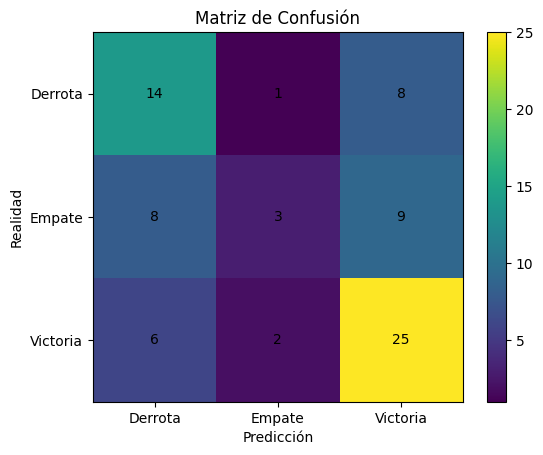

In [14]:
report = classification_report(y_real_seq, y_pred_seq, labels=[0,1,2], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"], zero_division=0)
print("\nReporte de Clasificación:\n", report)

cm = confusion_matrix(y_real_seq, y_pred_seq, labels=[0,1,2])
plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.xticks([0,1,2], ["Derrota", "Empate", "Victoria"])
plt.yticks([0,1,2], ["Derrota", "Empate", "Victoria"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        plt.text(col, row, cm[row, col], ha="center", va="center", color="black")

plt.show()

In [16]:
import mlflow
import dagshub
import os

# Configurar MLflow con DagsHub
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/{USERNAME}/{REPO_NAME}.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)

print(mlflow.get_tracking_uri())

with mlflow.start_run(run_name="ath_bilbao_nn_secuencial"):
    mlflow.log_param("model_type", "Neural Network")
    mlflow.log_param("approach", "NN + Sequential")
    mlflow.log_param("epochs", 20)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("test_size", 76)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Matriz de confusión estilo imshow
    cm = confusion_matrix(y_real_seq, y_pred_seq, labels=[0, 1, 2])

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (NN)")

    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            plt.text(col, row, cm[row, col], ha="center", va="center", color="black")

    # Guardar imagen
    cm_path = "conf_matrix_nn.png"
    plt.savefig(cm_path)
    plt.close()

    # Subir a MLflow
    mlflow.log_artifact(cm_path)
    os.remove(cm_path)

    print("Métricas y matriz de confusión registradas en MLflow.")


Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow
Métricas y matriz de confusión registradas en MLflow.
🏃 View run ath_bilbao_nn_secuencial at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/9111996787b6404886ba035fb6046cd5
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


#### Conclusión: Red Neuronal Secuencial para Athletic Bilbao

- **Precisión global:** 55.26%, lo que indica un rendimiento moderado general en la predicción partido a partido.
- **Predicción de derrotas:** Buen recall (0.61), aunque hay confusión con victorias.
- **Predicción de empates:** Bajo rendimiento (recall 0.15), la clase más difícil de predecir correctamente.
- **Predicción de victorias:** Mejor desempeño del modelo (f1-score 0.67), identifica bien este tipo de resultado.

- **Próximo paso:** Probar técnicas como PCA, balanceo de clases.


#### Red Neuronal con PCA y Pesos por Clase
- **Reducción de Dimensionalidad:** Aplicación de PCA para reducir ruido y posibles redundancias.
- **Balanceo de Clases:** Uso de pesos personalizados para compensar el desbalance entre clases.
- **Validación Secuencial:** Predicción partido a partido simulando uso en tiempo real.
- **Evaluación y Registro:** Métricas clave + matriz de confusión registradas en MLflow.


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from collections import Counter

In [19]:
# Cargar datos
df = pd.read_csv("../../datasets/datasets_equipos/ath_bilbao.csv")
df = df.drop(columns=["season", "date", "team"])
df["rival_team"] = LabelEncoder().fit_transform(df["rival_team"])

X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]

# Mapear etiquetas
label_map = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_map)

# Dividir en entrenamiento y validación
n_val = 76
X_train_init = X.iloc[:-n_val].copy()
y_train_init = y.iloc[:-n_val].copy()
X_val_seq = X.iloc[-n_val:].copy()
y_val_seq = y.iloc[-n_val:].copy()


In [20]:
# Escalado inicial
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)

# Aplicar PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Función para crear el modelo
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Inicializar listas
y_pred_seq = []
y_real_seq = []

#### ¿Qué hace `class_weight=class_weights`?

- Se utiliza para **corregir el desbalance entre clases** durante el entrenamiento del modelo.
- En problemas donde una clase aparece mucho más que otras (por ejemplo, muchas victorias y pocos empates), el modelo tiende a favorecer las clases mayoritarias.
- `class_weight` le asigna un peso mayor a las clases minoritarias para que el modelo **les preste más atención** al calcular el error.
- Los pesos se calculan de forma inversamente proporcional a la frecuencia de cada clase, lo que da más importancia a las clases menos representadas.
- Esto ayuda a **mejorar la precisión en clases minoritarias**, como los empates, sin necesidad de modificar el dataset.


In [21]:
# Validación secuencial con PCA
for i in range(n_val):
    model = build_model(X_train_pca.shape[1])

    y_train_mapped = y_train_init.map(label_map)
    y_train_cat = to_categorical(y_train_mapped, num_classes=3)

    class_counts = Counter(y_train_mapped)
    total = sum(class_counts.values())
    class_weights = {i: total / (len(class_counts) * class_counts[i]) for i in class_counts}

    model.fit(X_train_pca, y_train_cat, epochs=20, batch_size=32, verbose=0, class_weight=class_weights)

    X_next = X_val_seq.iloc[i:i+1]
    y_next = y_val_seq.iloc[i]
    y_real_seq.append(label_map[y_next])

    X_next_scaled = scaler.transform(X_next)
    X_next_pca = pca.transform(X_next_scaled)

    pred_prob = model.predict(X_next_pca)
    pred_label = np.argmax(pred_prob, axis=1)[0]
    y_pred_seq.append(pred_label)

    X_train_init = pd.concat([X_train_init, X_next])
    y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

    X_train_scaled = scaler.fit_transform(X_train_init)
    X_train_pca = pca.fit_transform(X_train_scaled)

1/1 [==============================] - 0s 127ms/step


In [22]:
# Métricas
accuracy = accuracy_score(y_real_seq, y_pred_seq)
precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

report = classification_report(y_real_seq, y_pred_seq, labels=[0,1,2], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"], zero_division=0)
print("\nReporte de Clasificación:\n", report)

Accuracy: 0.4605263157894737
Precision: 0.4737338028069231
Recall: 0.4605263157894737
F1: 0.4652678642110309

Reporte de Clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.58      0.48      0.52        23
  Empate (0)       0.26      0.30      0.28        20
Victoria (1)       0.53      0.55      0.54        33

    accuracy                           0.46        76
   macro avg       0.46      0.44      0.45        76
weighted avg       0.47      0.46      0.47        76



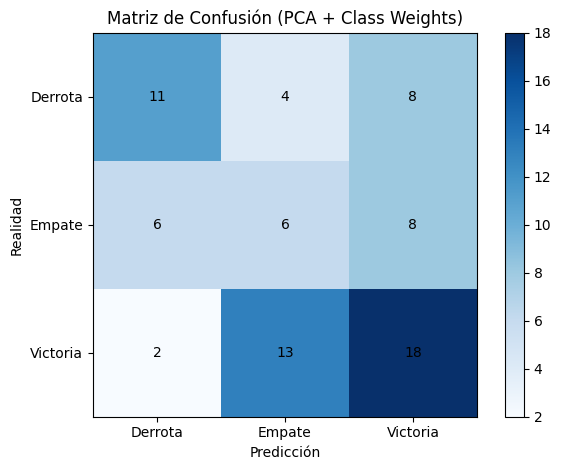

In [24]:
cm = confusion_matrix(y_real_seq, y_pred_seq, labels=[0,1,2])
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión (PCA + Class Weights)")

for row in range(cm.shape[0]):
    for col in range(cm.shape[1]):
        plt.text(col, row, cm[row, col], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()
plt.savefig("conf_matrix_pca_weights.png")
plt.close()

### Conclusión: Red Neuronal con PCA y Pesos por Clase

- **Precisión global:** 46.05%, inferior al modelo anterior pero con mejor equilibrio entre clases.
- **Predicción de derrotas:** Ligero descenso en recall (0.48) pero mejora en precisión.
- **Predicción de empates:** Se observa un progreso (recall sube a 0.30), aunque sigue siendo la clase más difícil.
- **Predicción de victorias:** Estable respecto al modelo anterior.

- **Próximo paso:** Aplicar Optuna para optimizar hiperparámetros del modelo y mejorar el balance entre precisión y recall.